**TLDR:**<br>
To skip to training or observing a convergent model in action, click `Run All`, proceed to the bottom of the notebook, and click the corresponding button.

# Cart World

From OpenAI's "Gym" library, Cart World has become a defacto "Hello, World!" of RL. The environment is relatively simple: a size 4 vector of 32-bit floats encapsulates the x coordinate of the pole's CoM, its speed, its angle to the cart, and its angular velocity. 

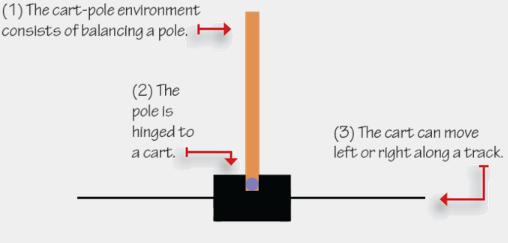

The environment simulates some base-level physics for the pole and cart, such that the pole will tip over unless the cart is moved to compensate for its motion, similar to trying to balance a pole upright on one's hand. The environment is configured to treat a fully-tipped-over pole as a terminal state.

The action-space is even more simple. In each time step, the cart can be instructed to move left or right.

Positive reward is given for each time-step during which the pole is not fully tipped over.

### Setting up Cart World
We initialize the `CartPole-v1` Environment, reset it in accordance with best practices, and do some preliminary exploration of its attributes and functions.

In [ ]:
import gym

Env = gym.make("CartPole-v1")
observation_1 = Env.reset()

#Show the action and observation-space properties
print(f"Number and type of actions: {Env.action_space}")
print(f"Observation Space type and size: {Env.observation_space}")

Number and type of actions: Discrete(2)
Observation Space type and size: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


Number and type of actions: Discrete(2)
Observation Space type and size: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [ ]:
# Actions: Env.step(action)
# We instruct the cart to go left, and receive a 5Tuple:
#   1. an observation from our new state
#   2. a reward (+1 for the pole not falling)
#   3. a "terminal state?" boolean (false, the pole hasn't fallen)
#   4. a "truncated?" boolean that indicates if our episode has
#      been ended by a non-terminal state end-condition/constraint.
#   5. extra_info. An often blank dict

print(Env.step(0))


(array([ 0.03966086, -0.21332754, -0.03749553,  0.24407718], dtype=float32), 1.0, False, False, {})


c:\Users\jfrie\Documents\GitHub\MyPortfolio\Finished\Python For DS and ML\RL, Gym, and Lapan\Cart Pole NB\env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


### The Random Agent
Here, an agent performs actions by taking steps based on random samples of the action-space. We record the means of the rewards and steps across multiple trials. Note that given the current reward configuration, this is somewhat redundant.

In [ ]:
class Agent:
    def __init__(self, Env, policy):
        self.Env = Env
        self.policy = policy

    def run_episode(self):
        self.Env.reset()
        total_reward = 0
        total_steps = 0
        while True:
            action = self.policy()
            obs,reward,done,trunc,_ = self.Env.step(action)
            total_reward += reward
            total_steps += 1
            if done:
                break
        return total_steps, total_reward
    

def collect_episodes(agent, num_episodes, verbose = False):
    e_steps = []
    e_rewards = []
    for i in range(num_episodes):
        s,r = agent.run_episode()
        e_steps.append(s)
        e_rewards.append(r)
    if verbose:
        print(f"{num_episodes} Episode Sampling:\n  Avg. Steps: {sum(e_steps)/len(e_steps)}\n  Avg. Reward: {sum(e_rewards)/len(e_rewards)}")
    return e_steps, e_rewards

rand_agent = Agent(Env, Env.action_space.sample)
e_steps, e_rewards = collect_episodes(rand_agent, 500, True)


500 Episode Sampling:
  Avg. Steps: 22.942
  Avg. Reward: 22.942


### Environment Wrappers

Gym's `Environment` class is responsible for the 3 communication channels between the agent and the environment. The `action_space`, `observation_space` and `reward`. 

We can alter the default Environment class using `Wrapper`, which inherits from `Environment`.

Additionally, we can specifically alter the behaviour of any of these 3 communication channels using the `ActionWrapper`, `ObservationWrapper`, and `RewardWrapper` classes specifically, to only expose the exact methods we want to override. Namely, the `action(action)`, `reward(reward)` and `observe(obs)` methods, respectively.

An example `ActionWrapper` is implemented below to introduce a probability of random-choice override of the action that was originally sent to the environment by the agent.

In [ ]:
import random
import numpy as np

# Implement an Epsilon % chance that a random action is taken
# instead of the one sent to the environment by the .step()
# method
class RandActionWrapper(gym.ActionWrapper):
    def __init__(self, env: Env, epsilon = 0.1):
        super().__init__(env)
        self.epsilon = epsilon

    def action(self, action):
        if random.random() < self.epsilon:
            # print("Random Action Taken!")
            return self.env.action_space.sample()
        return action

def left_policy():
    return 0

best_avg_reward = 0
best_epsilon = 9999
epsilon = 0
while epsilon <= 1:
    Env = RandActionWrapper(gym.make("CartPole-v1"), epsilon)
    left_agent = Agent(Env, left_policy)
    _,episode_rewards = collect_episodes(left_agent,500,False)
    avg_reward = np.mean(episode_rewards)
    if avg_reward > best_avg_reward:
        best_avg_reward = avg_reward
        best_epsilon = epsilon
    epsilon += 0.1
print(f"Highest Avg. Reward Achieved at Epsilon = {best_epsilon}")
print(f"Avg. Reward Achieved: {best_avg_reward}")

Highest Avg. Reward Achieved at Epsilon = 0.8999999999999999
Avg. Reward Achieved: 22.422


Notice that our left_only agent performs best when it's pratically replaced by the random agent by setting the random-action probability for the left-agent very close to 100%

In [ ]:
ACTION = 0
def left_right_policy():
    global ACTION 
    action = 0 if ACTION % 4 > 1 else 1
    ACTION += 1
    return action

Env = gym.make('CartPole-v1')
LR_agent = Agent(Env,left_right_policy)
_,_ = collect_episodes(LR_agent, 10,True)
Env.close()

10 Episode Sampling:
  Avg. Steps: 29.4
  Avg. Reward: 29.4


### A Deep RL Cart World
This diverges from the ordering of content in the Maxim Lapan book, as he chooses to step back from the CartPole environment for a stretch of time. 

For the sake of completeness, we use some very high level libraries from PyTorch to implement a deep RL agent that learns how to balance the pole very well.

Credit to [PyTorch.org](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) for the following code sections

##### Imports and Setup

In [ ]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Replay Memory
Two data structures: 
1. `Transition` pairs a (state, action) with a (next_state,reward) into a single Tuple. Represents a single transition in the MDP that comprises our environment.
2. `ReplayMemory` is a bounded size buffer that holds recent transitions and provides a way to sample them.

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

##### DQN Algorithm Overview:
This environment is deterministic, which is simpler than most RL environments. Standard RL literature will utilize expectations over stochastic transitions.

The goal of our policy is to maximize the discounted cumulative reward $R_{t0} = \sum^{\infty}_{t=t_0}\gamma^{t-t_0}r_t$, where $R_{t0}$ is also known as <i>return.</i> The discount, $\gamma$, is a constant, $\gamma \in[0,1]$. This ensures that the sum will converge as time, or $t$, progresses. Intuitively, this means that the far-future is less important to our agent, which is preferable in many cases. It does also encourage the agent to strongly prefer to choose near-term rewards over long term ones, however.

The notion of Q learning is that we attempt to emulate a perfect function that maps a $State \times Action$ pair to a perfectly-known return, $R$. If we had this function, called $Q^*$, then an optimal decision policy $\pi^*(s)$ would be simple: $$\pi^*(s) = argmax_{a}(Q^*(s,a))$$

Unfortunately, we aren't God, and do not have access to $Q^*$ for even  relatively simple scenarios. Thankfully, <i>neural networks</i>  allow us to play God somewhat, by serving as a very reliable and very flexible <i>function approximation tool</i> that can produce results similar to $Q^*$.

There is a useful fact which I won't relate the details of at this time that will be useful for defining a training-update rule. That is that every $Q$ function for some policy obeys the bellman equation: $$Q^\pi (s,a) = r+ \gamma Q^\pi(s', \pi(s'))$$

The difference between the two sides of the equality above are what defines the temporal difference error, often referred to as $\delta$:

$$\delta = Q(s,a) - (r+\gamma \max_{a}^{'}Q(s',a))$$

PyTorch suggests using Huber Loss. It's better at not over-reacting to outliers than MSE, since it doesn't square the error if it's too large. However, in practice we've determined that MSE works quite well with our chosen hyperparameters, and avoids the need for a conditional. This loss is calculated over a batch of transitions, $B$, from the replay memory.

$$\mathit{L} = \frac{1}{|B|}\sum_{(s,a,s',r)\in B} \mathit{L}(\delta)$$

$$where \quad \mathit{L}(\delta)=
\begin{cases}
\frac{1}{2}\delta^2 & \text{for } |\delta| \leq 1\\
|\delta|-\frac{1}{2} & \text{otherwise.}
\end{cases}$$

<h5 style="margin-bottom:8px; font-weight:bold; font-style: italic">The Q-Network:</h5>
A Feed Forward neural network that takes in the difference between the current and previous states as input in the form of a 4Tuple (s,a,r,s') 

It has two outputs, representing $Q(s,left)$ and $Q(s,right)$. In effect, the network is trying to predict the expected return of taking each action given the current input.

After allowing the network to estimate the quality of our possible actions, the agent moves, collects information about the state change, and stores it in the replay memory.

**Note:** After some extensive trial and error, we went with a slightly different setup for the DQN than the one perscribed by the PyTorch docs. The baseline work for this model can be credited to [Andrew Gordienko](https://andrew-gordienko.medium.com/reinforcement-learning-dqn-w-pytorch-7c6faad3d1e), who's model I only slightly tuned/adjusted to achieve an infallible agent.

##### To Train a New Agent, Run Here

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
env.reset()
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

EPISODES = 400
LEARNING_RATE = 0.0001
MEM_SIZE = 500000
BATCH_SIZE = 128
GAMMA = 0.999
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.9995
EXPLORATION_MIN = 0

FC1_DIMS = 512
FC2_DIMS = 1024
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space

        self.fc1 = nn.Linear(*self.input_shape, FC1_DIMS)
        self.fc2 = nn.Linear(FC1_DIMS, FC2_DIMS)
        self.fc3 = nn.Linear(FC2_DIMS, 512)
        self.fc4 = nn.Linear(512, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()
        self.to(DEVICE)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0
        
        self.states = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=bool)
    
    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE
        
        self.states[mem_index]  = state
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_
        self.dones[mem_index] =  1 - done

        self.mem_count += 1
    
    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)
        
        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

class DQN_Solver:
    def __init__(self, network = Network(), exploration_rate = EXPLORATION_MAX):
        self.memory = ReplayBuffer()
        self.exploration_rate = exploration_rate
        self.network = network

    def choose_action(self, observation):
        if random.random() < self.exploration_rate:
            return env.action_space.sample()
        
        state = torch.tensor(observation).float().detach()
        state = state.to(DEVICE)
        state = state.unsqueeze(0)
        q_values = self.network(state)
        return torch.argmax(q_values).item()
    
    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return
        
        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32).to(DEVICE)
        actions = torch.tensor(actions, dtype=torch.long).to(DEVICE)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        states_ = torch.tensor(states_, dtype=torch.float32).to(DEVICE)
        dones = torch.tensor(dones, dtype=torch.bool).to(DEVICE)
        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)

        q_values = self.network(states)
        next_q_values = self.network(states_)
        
        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0]
        
        q_target = rewards + GAMMA * predicted_value_of_future * dones

        loss = self.network.loss(q_target, predicted_value_of_now)
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate

agent = DQN_Solver()

Button(description='Train New Agent', layout=Layout(width='150px'), style=ButtonStyle())

Button(description='Run Existing Agent', layout=Layout(width='150px'), style=ButtonStyle())

c:\Users\jfrie\Documents\GitHub\MyPortfolio\Finished\Python For DS and ML\RL, Gym, and Lapan\Cart Pole NB\env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1 Average Reward 26.0 Best Reward 26.0 Last Reward 26.0 Epsilon 1.0
Episode 2 Average Reward 20.0 Best Reward 26.0 Last Reward 14.0 Epsilon 1.0
Episode 3 Average Reward 18.666666666666668 Best Reward 26.0 Last Reward 16.0 Epsilon 1.0
Episode 4 Average Reward 24.0 Best Reward 40.0 Last Reward 40.0 Epsilon 1.0
Episode 5 Average Reward 22.6 Best Reward 40.0 Last Reward 17.0 Epsilon 1.0
Episode 6 Average Reward 21.333333333333332 Best Reward 40.0 Last Reward 15.0 Epsilon 0.9995
Episode 7 Average Reward 24.857142857142858 Best Reward 46.0 Last Reward 46.0 Epsilon 0.9767682342250465
Episode 8 Average Reward 23.25 Best Reward 46.0 Last Reward 12.0 Epsilon 0.9709237146646298
Episode 9 Average Reward 22.666666666666668 Best Reward 46.0 Last Reward 18.0 Epsilon 0.9622224402159457
Episode 10 Average Reward 21.9 Best Reward 46.0 Last Reward 15.0 Epsilon 0.9550309756089804
Episode 11 Average Reward 21.636363636363637 Best Reward 46.0 Last Reward 19.0 Epsilon 0.9459988934677862
Episode 12 Av

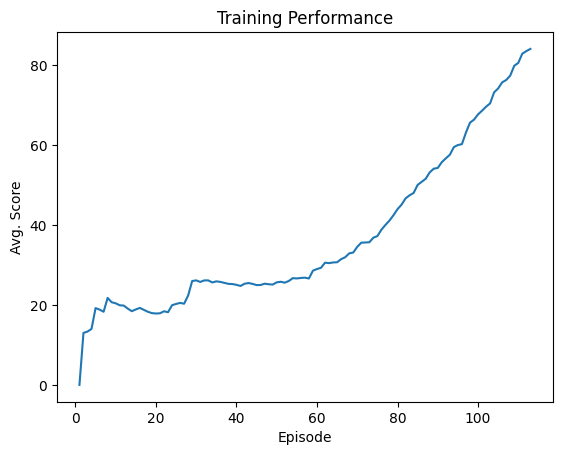

In [ ]:
import ipywidgets as widgets

def train_new(btn_inst):
    plt.title("Training Performance")
    plt.xlabel("Episode")
    plt.ylabel("Avg. Score")
    env = gym.make('CartPole-v1', render_mode="human")
    env.reset()
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    best_reward = 0
    average_reward = 0
    episode_number = []
    average_reward_number = []
    for i in range(1, EPISODES):
        try:
            state = env.reset()[0]
            state = np.reshape(state, [1, observation_space])
            score = 0
                
            while True:
                env.render()
                action = agent.choose_action(state)
                state_, reward, done, trunc, info = env.step(action)
                state_ = np.reshape(state_, [1, observation_space])
                agent.memory.add(state, action, reward, state_, done)
                agent.learn()
                state = state_
                score += reward

                if done or score > 10000:
                    if score > best_reward:
                        best_reward = score
                    average_reward += score 
                    print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
                    break
            
                episode_number.append(i)
                average_reward_number.append(average_reward/i)
                
                if average_reward/i > 500:
                    break
        except KeyboardInterrupt as e:
            print("Training Interrupted by user! Agent-State Not Saved!")
            plt.plot(episode_number, average_reward_number)
            plt.show()
            env.close()
            return
        
    torch.save(agent.network.state_dict(), "supermodel.pt")
    plt.plot(episode_number, average_reward_number)
    plt.show()
    env.close()
    return

# torch.save(agent.network.state_dict(), "supermodel.pt")
def run_saved(btn_inst):
    env = gym.make('CartPole-v1', render_mode="human")
    env.reset()
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    best_reward = 0
    average_reward = 0
    episode_number = []
    average_reward_number = []
    model = Network()
    model.load_state_dict(torch.load("supermodel.pt"))
    model.eval()
    trained_agent = DQN_Solver(model, 0)
    try:
        for i in range(1, 10):
            state = env.reset()[0]
            state = np.reshape(state, [1, observation_space])
            score = 0

            while True:
                env.render()
                action = trained_agent.choose_action(state)
                state_, reward, done, trunc, info = env.step(action)
                state_ = np.reshape(state_, [1, observation_space])
                trained_agent.memory.add(state, action, reward, state_, done)
                state = state_
                score += reward

                if done or score > 50000:
                    if score > best_reward:
                        best_reward = score
                    average_reward += score 
                    print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, trained_agent.returning_epsilon()))
                    break

                episode_number.append(i)
                average_reward_number.append(average_reward/i)

        
        env.close()
    except KeyboardInterrupt as e:
        print("Episode: {} Reward: {} Epsilon: {}".format(i, score, trained_agent.returning_epsilon()))
        env.close()
    
    plt.title("Performance of Saved Model")
    plt.xlabel("Episode")
    plt.ylabel("Avg. Score")
    plt.plot(episode_number, average_reward_number)
    plt.show()



style_1 = {'background-color': '#3498db', 'color': 'white', 'border': 'none'}
style_2 = {'background-color': '#e74c3c', 'color': 'white', 'border': 'none'}

newBtn = widgets.Button(description='Train New Agent',
                        layout=widgets.Layout(width='150px'),
                        style = style_1)
currBtn = widgets.Button(description='Run Existing Agent',
                         layout=widgets.Layout(width='150px'),
                         style = style_2)
newBtn.on_click(train_new)
currBtn.on_click(run_saved)

display.display(newBtn,currBtn)